## Analyzing the Impact of Agricultural Policies on Population Health in the United States

<h3> The Problem </h3>


Our aim is to understand if **agricultural policies** in the US are increasing the average calorie intake per person in the US, resulting in increased obesity and decreased population health.
<h3>Population Health</h3>


An ideal <a href="https://en.wikipedia.org/wiki/Population_health">population health</a> outcome metric should reflect a population’s dynamic state of physical, mental, and social well-being. <font color='green'>Positive health</font> outcomes include being **alive**; functioning well **mentally, physically, and socially**; and having a sense of **well-being**. <font color='red'>Negative</font> outcomes include **death**, **loss of function**, and **lack of well-being**. In contrast to these health outcomes, diseases and injuries are intermediate factors that influence the likelihood of achieving a state of health. On the basis of a review of outcomes metrics currently in use and the availability of data for at least some US counties,the following metrics for population health outcomes are recommended: 

1. Life expectancy from birth, or age-adjusted mortality rate.
2. Condition-specific changes in life expectancy, or condition-specific or age-specific mortality rates 
3. Self-reported level of health, functional status, and experiential status. 

When reported, outcome metrics should present both the overall level of health of a population and the distribution of health among different geographic, economic, and demographic groups in the population.

In this project, we use measures such as - 
1. Death Rate by *state*
2. Death Rate due to *endocrine and nutritional issues by state*
3. Obesity Levels by *state and demographics*

as a measure of **poplulation health**.

<h3>Agricultural Policies</h3>

The agricultural policies in the US are generally referred to as <a href="https://www.ers.usda.gov/agricultural-act-of-2014-highlights-and-implications/">farm bill</a>. The latest farm bill was introduced in 2014 and a new bill is due in 2019.

The model the agricultural policies, we use the following variables - 

1. Corn Prices (\$/bushel) by *state*
2. Soybean Prices (\$/bushel) by *state*
3. Subsidies going to corn and soybean productions

In addition to that we will also include the qualitative analysis on the growth of fast food consumption and the price of fast food in the US.

### Importing libraries

In [1]:
#####################################################################
# Data visualization using Bokeh
#####################################################################
import bokeh
from bokeh.io import show
from bokeh.io import output_notebook
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LinearColorMapper
)
from bokeh.palettes import Viridis6 as palette
from bokeh.palettes import small_palettes as small_palettes
from bokeh.plotting import figure
from bokeh.models import CustomJS, Slider, Legend, LegendItem
from bokeh.layouts import row, widgetbox
from bokeh.sampledata.us_states import data as states
from bokeh.models import LinearColorMapper, LinearScale, ColorBar

#####################################################################
# Basic Python libs
#####################################################################

import csv
import sqlite3
import pandas as pd
import numpy as np
import math
import matplotlib

from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import interactive

matplotlib.use("svg")

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

output_notebook()

Loading BokehJS ...

## The Data Sources

The availability agricultural data is quite abundant and we leveraged several such sources to get our data.

1. Death rate data - <a href="https://wonder.cdc.gov/">Center for Disease Control</a> - 2000 rows
2. Agricultural Data - <a href="https://data.ers.usda.gov/FEED-GRAINS-custom-query.aspx">USDA</a> - 438697 rows
3. Obesity data - <a href="https://catalog.data.gov/dataset?tags=obesity"> DATA.gov</a> - 53392 rows


### Unix Area

In [2]:
datadir = "../data/"
!ls -lrt ../data

total 417792
-rw-r--r--@ 1 rohansingh  staff  81131198 Mar  9 08:49 FeedGrains.csv
-rw-r--r--@ 1 rohansingh  staff   4773458 Apr 12 00:18 FeedGrains.zip
-rw-r--r--  1 rohansingh  staff  79233024 Apr 12 00:28 feedgrain.db
-rw-r--r--  1 rohansingh  staff         0 Apr 12 01:01 FeedGrains.db
-rw-r--r--@ 1 rohansingh  staff    151999 Apr 16 21:47 Analysis_Tableau.twb
-rw-r--r--@ 1 rohansingh  staff     64517 Apr 16 22:30 Analysis_Tableau_AdCampaign.twb
-rw-r--r--@ 1 rohansingh  staff     37081 Apr 24 20:27 tax_per_operation_by_state_corn.csv
-rw-r--r--@ 1 rohansingh  staff   1607687 May  6 18:16 death_rate_data_1999_2016.txt
-rw-r--r--@ 1 rohansingh  staff     49268 May  6 18:34 death_rate_by_state_year.txt
-rw-r--r--@ 1 rohansingh  staff     50546 May  6 19:21 death_nutrional_endocrine_by_state_year.txt
-rw-r--r--@ 1 rohansingh  staff  20397291 May  8 10:24 nutrition_physical_activity_raw.csv.backup
-rw-r--r--  1 rohansingh  staff     58833 May  8 10:31 obesity_data_by_state_year.csv
-rw-

### Cleaning the data retrieved from CDC website.

In [3]:
"""
This subroutine cleans and formats data.
"""
def clean_data(filename, **kwargs):
    """
    Takes a filenane to generate clean data for data retrieved from CDC.
    Args:
        filename : Raw filename downloaded from CDC website
        **kwargs['remove_cols'] : Columns that need to dropped
    Returns:
        df : clean dataframe
    """
    
    df = pd.read_csv(datadir + filename, sep="\t")
    df = df[df['Notes'].isnull()]
    df = df.drop('Notes', axis=1)
    df = df.drop(kwargs['remove_cols'], axis=1)
    # death_rate_data = death_rate_data[death_rate_data['Crude Rate'] != 'Unreliable']
    df['Crude Rate'] = df['Crude Rate'].astype(float)
    df['Year'] = df['Year'].astype(int)
    return df

In [4]:
"""
This subroutine helps visualize a data value for all states and years
"""
def plot_all_states(df):
    """
    Args:
        df(dataframe) : a dataframe consisting of year, state, and value column.
    Outputs:
        plot showing value for all states
    """
    legend = []
    plt.figure(figsize=(15,10))
    for state in df['State'].unique():
        df1 = df[df['State'] == state]
        plt.plot(df1['Year'], df1['Crude Rate'])
        legend.append(state)
    plt.xticks(df['Year'].unique())
    plt.legend(legend,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Death rate by state

We see here that the death rate across states have been fairly constant over the years for all the states. 

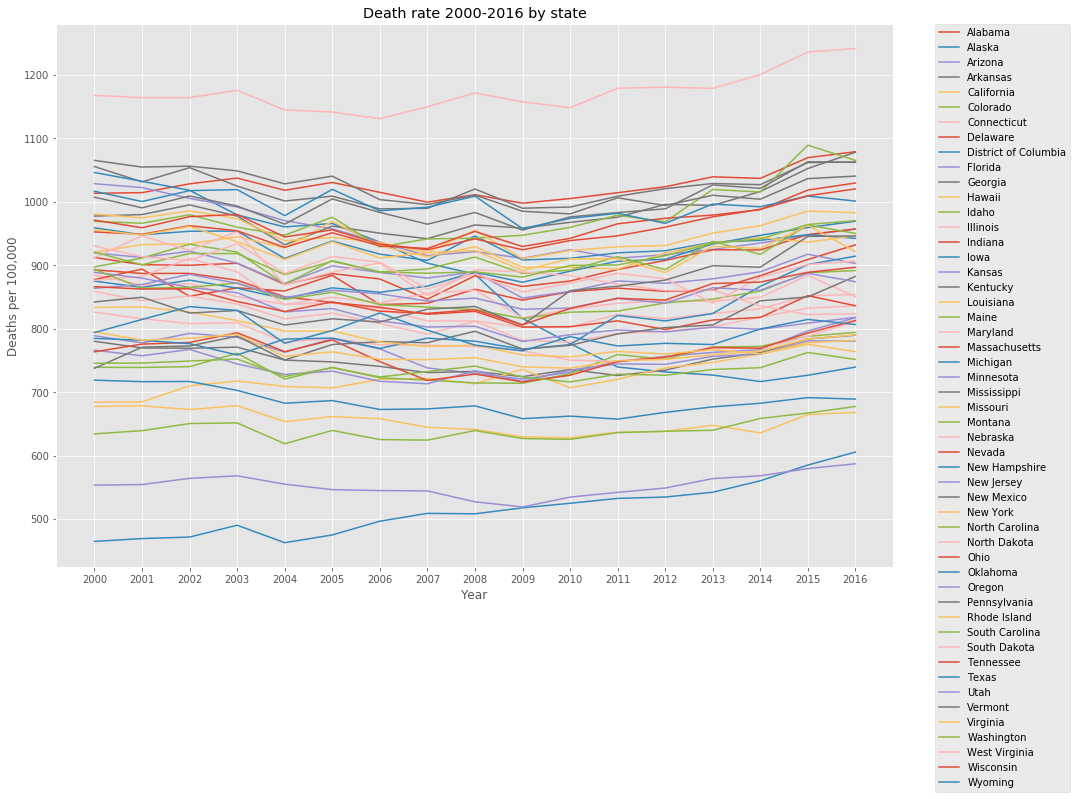

In [5]:
death_rate_state_year = clean_data('death_rate_by_state_year.txt', remove_cols=['State Code', 'Year Code'])
plot_all_states(death_rate_state_year)
plt.xlabel("Year")
plt.ylabel("Deaths per 100,000")
plt.title("Death rate 2000-2016 by state");

### Death rate by nutrional and endocrine by state

As we wanted to analyze the effect of agricultural and food policies on the population health. We got the data regarding the deaths caused by endocrine or nutrition related problems to better understand the problem at hand.

Here we observed that the data shows a lot of variations amongst states which conforms to our assumption that obesity and obesity related deaths have been on  rise 

Year       State  Deaths  Population  Crude Rate
0  1999     Alabama  1772.0   4430141.0        40.0
1  1999      Alaska    88.0    624779.0        14.1
2  1999     Arizona  1370.0   5023823.0        27.3
3  1999    Arkansas   967.0   2651860.0        36.5
4  1999  California  8219.0  33499204.0        24.5

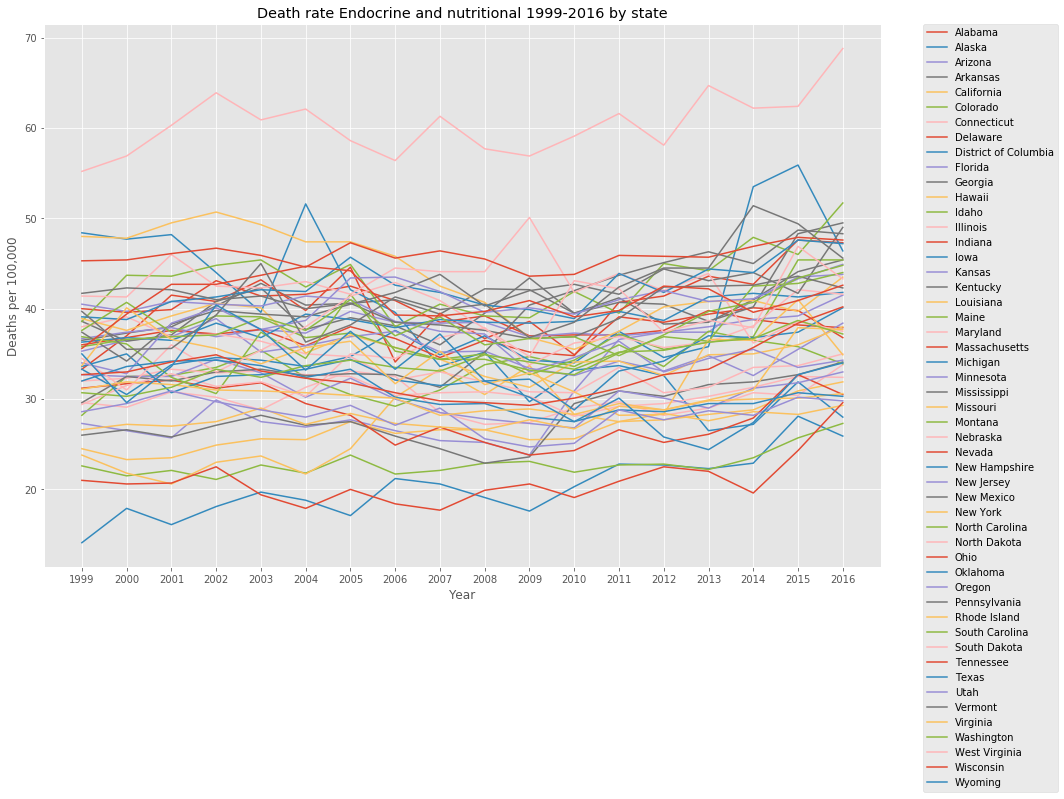

In [6]:
death_nutritional_state_year = clean_data('death_nutrional_endocrine_by_state_year.txt', 
                                          remove_cols=['State Code', 'Year Code'])
plot_all_states(death_nutritional_state_year)
plt.xlabel("Year")
plt.ylabel("Deaths per 100,000")
plt.title("Death rate Endocrine and nutritional 1999-2016 by state");
death_nutritional_state_year.head()

### Widget to plot each state separately

Next we wanted to delve deeper into data for each state for deaths. For this we created a widget for exploring the statewise data for states using a dropdown menu.

In [7]:
"""
This subroutine is used by an interactive widget to plot the rates given a state.
"""
def plot_state(df,state):
    """
    Args:
        df (dataframe) :  a dataframe consisting of year, state, and value column.
        state : the state for which the interactive plot is shown.
    Outputs:
        Show a matplotlib plot
    """
    min_cr = min(df['Crude Rate'])
    max_cr = max(df['Crude Rate'])
    df1 = df[df['State'] == state]
    plt.plot(df1['Year'], df1['Crude Rate'])
    plt.legend([state])
    plt.xlim(2000,2016)
    plt.ylim(min_cr,max_cr)
    plt.xlabel("Year")
    plt.ylabel("Deaths per 100,000")
    plt.show()
    

### View death rate by state ( Interactivily )

In [8]:
l = [(k,k) for k in death_rate_state_year['State'].unique()]
w = widgets.Select(options=l,description='Select State:')
state = 'Alabama'
    
interactive_plot = interactive(plot_state, df=fixed(death_rate_state_year),state=l)
interactive_plot

### View deaths due to nutrition (broad category) 

In [9]:
l = [(k,k) for k in death_nutritional_state_year['State'].unique()]
w = widgets.Select(options=l,description='Select State:')
state = 'Alabama'
    
interactive_plot = interactive(plot_state, df=fixed(death_nutritional_state_year),state=l)
interactive_plot

The interactive map was used to see trends pertaining to states and death rate changes over the years. We found that endocrine and nutrition related deaths have been increasing.

## Visualize state wise data on static map

Next, to see how the data is spread across the United States, we wrote a subroutine to show different rates on a map.
For this task, we utilized the amazing python data visualization library called "Bokeh"

In [ ]:
def plot_on_map(df, max_rate=0, min_rate=100,year=2015):
    """
    Plot Data on the an interactive US MAP
    """
    
    EXCLUDED = ("ak", "hi", "pr", "gu", "vi", "mp", "as")
    color_mapper = LinearColorMapper(palette=palette, high=max_rate, low=min_rate)
    
    for state in EXCLUDED:
        if state.upper() in states:
            del states[state.upper()]
            
#     palette.reverse()
    state_codes = {
        code: state for code, state in states.items() if state not in EXCLUDED
    }

    state_xs = [states[code]["lons"] for code in state_codes]
    state_ys = [states[code]["lats"] for code in state_codes]
    state_names = [state['name'] for state in state_codes.values()]
    color_mapper = LinearColorMapper(palette=palette, high=max_rate, low=min_rate)

    state_rates = [df[(df['State']==state_codes[state_id]['name']) 
                                   & (df['Year']==year)]['Crude Rate'] for state_id in state_codes]

    dummy = np.random.randn(len(state_rates))
    years1 = pd.DataFrame({'year': str(year) , 'dummy': dummy})
    years1 = years1.drop(['dummy'], axis=1)
    years1 = years1['year']

    source = ColumnDataSource(data=dict(
        x=state_xs,
        y=state_ys,
        name=state_names,
        rate=state_rates,
        year = years1
    ))

    TOOLS = "pan,wheel_zoom,reset,hover,save"
    
    p = figure(
        title="State-wise crude death rates {}".format(year),tools=TOOLS,
        x_axis_location=None, y_axis_location=None, plot_width=250, plot_height=250
        
    )
    p.grid.grid_line_color = None

    p.patches('x', 'y', source=source,
              fill_color={'field': 'rate', 'transform': color_mapper},
              fill_alpha=0.7, line_color="white", line_width=0.5)

    hover = p.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [
        ("Name", "@name"),
        ("Crude Death Rate", "@rate"),
        ("Year", "@year"),
    ]
    
    return p


### Visualizing data over the year on a map

We also figured data to analyze the impact of policies on health, we need a tool to go over years of data and see which places are most affected. This is required for doing a root cause analysis of the problem.

In [30]:
def plot_on_map_with_slider(df, max_rate, min_rate):
    """
    Plot CDC Data on the US Map with year slider
    """
    small_palettes['Reds'][9].reverse()
    EXCLUDED = ("ak", "hi", "pr", "gu", "vi", "mp", "as")
    
    for state in EXCLUDED:
        if state.upper() in states:
            del states[state.upper()]
            
    states_dict = {
        code: state for code, state in states.items() if str(state).lower() not in EXCLUDED
    }
    state_xs = [states_dict[code]["lons"] for code in states_dict]
    state_ys = [states_dict[code]["lats"] for code in states_dict]
    
    state_names = [state['name'] for state in states_dict.values()]
    color_mapper = LinearColorMapper(palette=small_palettes['Reds'][9], high=max_rate, low=min_rate)

    sources = {}
    years = list(df['Year'])
    state_rates = {}
    min_year = min(years)
    max_year = max(years)
    for year in years:
        x = state_xs,
        y = state_ys,
        name = state_names,
        state_rates[str(year)] = [df[(df['State']==states[state_id]['name']) 
                                   & (df['Year']==year)]['Crude Rate'] for state_id in states]
    
#     state_rates_1999 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==1999)]['Crude Rate'] for state_id in states]
#     state_rates_2000 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2000)]['Crude Rate'] for state_id in states]
#     state_rates_2001 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2001)]['Crude Rate'] for state_id in states]
#     state_rates_2002 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2002)]['Crude Rate'] for state_id in states]
#     state_rates_2003 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2003)]['Crude Rate'] for state_id in states]
#     state_rates_2004 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2004)]['Crude Rate'] for state_id in states]
#     state_rates_2005 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2005)]['Crude Rate'] for state_id in states]
#     state_rates_2006 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2006)]['Crude Rate'] for state_id in states]
#     state_rates_2007 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2007)]['Crude Rate'] for state_id in states]
#     state_rates_2008 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2008)]['Crude Rate'] for state_id in states]
#     state_rates_2009 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2009)]['Crude Rate'] for state_id in states]
#     state_rates_2010 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2010)]['Crude Rate'] for state_id in states]
#     state_rates_2011 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2011)]['Crude Rate'] for state_id in states]
#     state_rates_2012 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2012)]['Crude Rate'] for state_id in states]
#     state_rates_2013 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2013)]['Crude Rate'] for state_id in states]
#     state_rates_2014 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2014)]['Crude Rate'] for state_id in states]
#     state_rates_2015 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2015)]['Crude Rate'] for state_id in states]
#     state_rates_2016 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2016)]['Crude Rate'] for state_id in states]

    source = ColumnDataSource(data=dict(
        x=state_xs,
        y=state_ys,
        name=state_names,
        rate=state_rates['2011']
#         rate=state_rates_2011,
#         rate=df['Crude Rate'],
#         rate_2000=state_rates_2000,
#         rate_2001=state_rates_2001,
#         rate_2002=state_rates_2002,
#         rate_2003=state_rates_2003,
#         rate_2004=state_rates_2004,
#         rate_2005=state_rates_2005,
#         rate_2006=state_rates_2006,
#         rate_2007=state_rates_2007,
#         rate_2008=state_rates_2008,
#         rate_2009=state_rates_2009,
#         rate_2010=state_rates_2010,
#         rate_2011=state_rates_2011,
#         rate_2012=state_rates_2012,
#         rate_2013=state_rates_2013,
#         rate_2014=state_rates_2014,
#         rate_2015=state_rates_2015,
#         rate_2016=state_rates_2016
    ))

    TOOLS = "pan,wheel_zoom,reset,hover,save"

    p = figure(
        title="Nutrition Related Deaths", tools=TOOLS,
        x_axis_location=None, y_axis_location=None
    )
    p.grid.grid_line_color = None

    p.patches('x', 'y', source=source,
              fill_color={'field': 'rate', 'transform': color_mapper},
              fill_alpha=0.7, line_color="white", line_width=0.5)

    color_mapper = LinearColorMapper(palette=small_palettes['Reds'][9], low=min_rate, high=max_rate)
    color_bar = ColorBar(color_mapper=color_mapper, 
                 label_standoff=12, border_line_color=None, location=(0,0))
    p.add_layout(color_bar, 'right')
    
    slider = Slider(start=min_year, end=max_year, value=years[0], step=1, title="Year")
    

    def update(source=source, slider=slider, window=None):
        """ 
        Update the map: change the bike density measure according to slider
            will be translated to JavaScript and Called in Browser 
        """
        data = source.data
        v = cb_obj.get('value')
        print(v)
        data['rate'] = [x for x in data['rates'][v]]
        source.trigger('change')

    slider.js_on_change('value', CustomJS.from_py_func(update))
    show(row(p,widgetbox(slider),))
#     hover = p.select_one(HoverTool)
#     hover.point_policy = "follow_mouse"
#     hover.tooltips = [
#         ("Name", "@name"),
#         ("Crude Death Rate", "@rate_"+ str(year))]
    
#     callback = CustomJS(args=dict(source=source), code="""
#         var year = year.value;
#         var data = source.data;
#         var col = 'rate_' + year
#         data['rate'] = data['rate'][year]
#         source.change.emit();
#     """)
    
    
#     year_slider = Slider(start=2011, end=years[-1], value=years[0], step=1,
#                         title="Year", callback=callback)
#     callback.args["year"] = year_slider

#     layout = row([p,year_slider])

#     show(layout)


In [31]:
max_cr = max(death_nutritional_state_year['Crude Rate'])
min_cr = min(death_nutritional_state_year['Crude Rate'])
plot_on_map_with_slider(death_nutritional_state_year, max_cr, min_cr)
# show(plot_on_map(death_nutritional_state_year, max_cr, min_cr))

## Obesity Data

### Analyse the obesity data

In [ ]:
raw_obestity = pd.read_csv(datadir + 'nutrition_physical_activity_raw.csv')

### Get obesity data for US and states

In [ ]:
### DO NOT CHANGE THIS CELL ###
def clean_obesity(df):

    df = df[df['Data_Value_Footnote'].isnull()]

    df = df.drop(["YearEnd", 'Datasource', 'Class', 'Topic', 'Data_Value_Unit','Data_Value_Type',
                    'Data_Value_Alt', 'Data_Value_Footnote', 'Data_Value_Footnote_Symbol','Low_Confidence_Limit',
                     'High_Confidence_Limit ', 'Sample_Size', 'GeoLocation','ClassID','TopicID',
                      'DataValueTypeID','LocationID'], axis = 1)
    df_us = df[df['Total'] == 'Total']
    df_states = df[df['Total'] != 'Total']
    return df_us, df_states
obesity_us, obesity_states = clean_obesity(raw_obestity)
print(len(obesity_us))
print(len(obesity_states))
obesity_states.head(1)

### Get mappings

In [ ]:
question_map = dict(zip(obesity_states['QuestionID'],obesity_states['Question']))
obesity_states_features = obesity_states.drop(['Question', 'Total'], axis = 1)
question_map

### Create features

In [ ]:
obesity_without_states = obesity_states_features.drop(['StratificationCategory1', 'Stratification1',
                                                       'StratificationCategoryId1', 'StratificationID1', 
                                                       'LocationDesc', 'YearStart' , 'LocationAbbr'], axis=1)
obesity_states_features = obesity_states_features.drop(['StratificationCategory1', 'Stratification1',
                                                        'StratificationCategoryId1', 'StratificationID1', 
                                                        'LocationDesc'], axis=1)


In [ ]:
obesity_features = pd.get_dummies(obesity_states_features)
obesity_features_without_year = obesity_features.drop(['YearStart'], axis=1)
obesity_features_without_year.head()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
regr = RandomForestClassifier(max_depth=2, random_state=0)
regr.fit(X, y)
print(X.columns[np.nonzero(regr.feature_importances_)])
regr.score(X,y)

### Only demographic features

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def rndm_forest_non_state(df):
    df = pd.get_dummies(df)
    df = df.drop(['QuestionID_Q036','QuestionID_Q037','QuestionID_Q047','QuestionID_Q043','QuestionID_Q046',
                 'QuestionID_Q044','QuestionID_Q046'],axis=1)
    X = df.loc[:, df.columns != 'Data_Value']
    y = df.loc[:,'Data_Value'] 
    
    y = y.apply(lambda x: 0 if x<y.mean() else 1)
    regr = RandomForestClassifier(max_depth=3, random_state=0)
    regr.fit(X, y)
    l_ = regr.feature_importances_
    idx = np.argpartition(l_, -7)[-7:]
    print(X.columns[idx])
    print(regr.score(X,y))
    
rndm_forest_non_state(obesity_without_states_features)

In [ ]:
from sklearn.linear_model import LogisticRegression
def log_ref_non_state(df):
    df = pd.get_dummies(df)
    df = df.drop(['QuestionID_Q036','QuestionID_Q037','QuestionID_Q047','QuestionID_Q043','QuestionID_Q046',
                 'QuestionID_Q044','QuestionID_Q046'],axis=1)
    X = df.loc[:, df.columns != 'Data_Value']
    y = df.loc[:,'Data_Value'] 
    
    y = y.apply(lambda x: 0 if x<y.mean() else 1)
    regr = LogisticRegression()
    regr.fit(X, y)
    l_ = regr.coef_
    idx = np.argpartition(l_, -7)[-7:]
    print(X.columns[idx])
    print(regr.score(X,y))
log_ref_non_state(obesity_without_states_features)

In [ ]:
plt.hist(obesity_states_features[obesity_states_features['Age(years)'] == 'Female']['Data_Value'],bins=20)

In [ ]:
print(obesity_states_features['Age(years)'].unique())
plt.hist(obesity_states_features[obesity_states_features['Gender'] == 'Female']['Data_Value'],bins=20)

In [ ]:
plt.hist(obesity_states_features[obesity_states_features['Gender'] == 'Male']['Data_Value'],bins=20)

### Corn Price Analysis


In [ ]:
corn_prices = pd.read_csv(datadir + 'corn_prices_by_state.csv')
corn_prices = corn_prices.drop(['Program', 'State ANSI', 'Data Item'], axis = 1)
corn_prices.columns = ['Year', 'State', 'Crude Rate']
corn_prices.head()

In [ ]:
plt.hist(corn_prices['Crude Rate'],bins=100)

#### Visualizing Corn prices for states

In [ ]:
plot_all_states(corn_prices)
plt.xlabel("Year")
plt.ylabel('Corn Prices')
plt.title("Corn Prices 2011-17")

In [ ]:
obesity_hypothesis = obesity_us[obesity_us['QuestionID'] == 'Q036'].loc[:,['YearStart', 'LocationDesc', 'Data_Value']]

In [ ]:
obesity_hypothesis.columns = ['Year', 'State', 'Crude Rate']
obesity_hypothesis['State'] = obesity_hypothesis['State'].apply(lambda x: x.upper())
obesity_hypothesis.head()
obesity_hypothesis.dtypes

In [ ]:
corn_prices.head()
corn_prices.dtypes

In [ ]:
df_hyp1 = pd.merge(obesity_hypothesis, corn_prices, how='inner',on=['Year', 'State'])
df_hyp1
linregress(df_hyp1['Crude Rate_y'], df_hyp1['Crude Rate_x'])
# linregress(df_hyp1[df_hyp1['State'] == 'Alabama']['Crude Rate_x'], df_hyp1[df_hyp1['State'] == 'Alabama']['Crude Rate_y'])

In [ ]:
from scipy.stats import linregress
linregress
plt.scatter(df_hyp1['Crude Rate_y'], df_hyp1['Crude Rate_x'])
plt.plot(df_hyp1['Crude Rate_y'], -0.6712310777406808*df_hyp1['Crude Rate_y'] + 32.871051260496607, '-', color='blue')
plt.xlabel("Corn Prices")
plt.ylabel("Obesity")
plt.title("Correlation between corn prices and obesity")
plt.legend()

In [ ]:
max_cr = max(obesity_hypothesis['Crude Rate'])
min_cr = 0
obesity_hypothesis['State'] = obesity_hypothesis['State'].apply(lambda x: x.title())
plot_on_map_with_slider(obesity_hypothesis,max_cr, min_cr)
# obesity_hypothesis